In [5]:
import argparse
import os

import numpy as np
from config import constants, environment, setting
import matplotlib.pyplot as plt

import simcomm.core.propagation as prop
from simcomm.core import STAR, LinkCollection, Receiver, Simulator, Transmitter
from simcomm.utils import dbm2pow, pow2db, pow2dbm, db2pow, qfunc
from colorama import Fore, Style

In [13]:
environment = {
    "positions": {
        "BS1": [-50, 0, 25],  # BS1 position
        "BS2": [50, 0, 25],  # BS2 position
        "RIS": [0, 25, 5],  # RIS position
        "Uf": [0, 35, 1],  # Uf position
        "U1c": [-40, 18, 1],  # U1c position
        "U2c": [30, 22, 1],  # U2c position
    },
    "fading": {
        "rayleigh": {"type": "rayleigh", "sigma": 1},  # Rayleigh fading
        "ricianE": {
            "type": "rician",
            "K": 4,
            "sigma": 1,
        },  # Rician fading for edge users
        "ricianC": {
            "type": "rician",
            "K": 3,
            "sigma": 1,
        },  # Rician fading for center users
    },
    "pathloss": {
        "center": {"type": "free-space", "alpha": 3, "p0": 30},  # Center users
        "ris": {"type": "free-space", "alpha": 3, "p0": 30},  # BS to RIS
        "risC": {"type": "free-space", "alpha": 2.7, "p0": 30},  # RIS to center users
        "risE": {"type": "free-space", "alpha": 2.3, "p0": 30},  # RIS to edge user
        "edge": {"type": "free-space", "alpha": 3.5, "p0": 30},  # Edge users
        "inter": {"type": "free-space", "alpha": 4, "p0": 30},  # Interference links
    },
}

setting = {
    "ris32": {
        "ris_enhanced": True,  # RIS with 32 elements
        "ris_elements": 32,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": True,  # CoMP enabled"
    },
    "ris70": {
        "ris_enhanced": True,  # RIS with 70 elements
        "ris_elements": 70,
        "comp_enabled": True,  # CoMP enabled
    },
    "no_ris_non_comp": {
        "ris_enhanced": False,  # No RIS
        "comp_enabled": False,  # CoMP disabled
    },
}

constants = {
    "BANDWIDTH": 1e6,  # Bandwidth in Hz
    "TEMP": 300,  # Temperature in Kelvin
    "FREQ": 2.4e9,  # Frequency of carrier signal in Hz
    "SIGMA": 6.32,  # Shadowing standard deviation in dB
}

In [14]:
all_results = []  # Store all results

In [16]:
link_option = "ris70"  # Select the link option
N = 10000  # Number of samples

# Load the environment
pathloss_cfg = environment["pathloss"]
fading_cfg = environment["fading"]
positions = environment["positions"]

# Additional parameters
BANDWIDTH = constants["BANDWIDTH"]  # Bandwidth in Hz
TEMP = constants["TEMP"]  # Temperature in Kelvin
FREQ = constants["FREQ"]  # Frequency of carrier signal in Hz
SIGMA = constants["SIGMA"]  # Shadowing standard deviation in dB

Pt = np.linspace(-50, 30, 161)  # Transmit power in dBm
Pt_lin = dbm2pow(Pt)  # Transmit power in linear scale
N0 = prop.get_noise_power(BANDWIDTH, TEMP, 12)  # Noise power in dBm
P_circuit = 10 ** (-3)  # Circuit power in watts

params = setting[link_option]
ris_enhanced = params["ris_enhanced"]  # Whether to use RIS-enhanced transmission
comp_enabled = params["comp_enabled"]  # Whether to use computation offloading

# Create the base stations
BS1 = Transmitter("BS1", positions["BS1"], Pt_lin, {"U1c": 0.3, "Uf": 0.7})
BS2 = Transmitter("BS2", positions["BS2"], Pt_lin, {"U2c": 0.3, "Uf": 0.7})

# Create the users (identical)
U1c = Receiver("U1c", positions["U1c"], sensitivity=-110)
U2c = Receiver("U2c", positions["U2c"], sensitivity=-110)
Uf = Receiver("Uf", positions["Uf"], sensitivity=-110)

# Initialize the link collection (containing channel information)
links = LinkCollection(N, FREQ)

# Add the center links to the collection
links.add_link(BS1, U1c, fading_cfg["rayleigh"], pathloss_cfg["center"], "1,c")
links.add_link(BS2, U2c, fading_cfg["rayleigh"], pathloss_cfg["center"], "2,c")

# Add the edge links to the collection
links.add_link(BS1, Uf, fading_cfg["rayleigh"], pathloss_cfg["edge"], "f")
links.add_link(BS2, Uf, fading_cfg["rayleigh"], pathloss_cfg["edge"], "f")

# Add interference links to the collection
links.add_link(BS1, U2c, fading_cfg["rayleigh"], pathloss_cfg["inter"], "i,c")
links.add_link(BS2, U1c, fading_cfg["rayleigh"], pathloss_cfg["inter"], "i,c")

In [17]:
K = params["ris_elements"]  # Number of RIS elements

# Create the STAR-RIS element
RIS = STAR("RIS", positions["RIS"], elements=K)

# Add the RIS links to the collection
links.add_link(BS1, RIS, fading_cfg["ricianC"], pathloss_cfg["ris"], "ris,b1")
links.add_link(BS2, RIS, fading_cfg["ricianC"], pathloss_cfg["ris"], "ris,b2")
links.add_link(RIS, U1c, fading_cfg["ricianC"], pathloss_cfg["risC"], "ris,b1")
links.add_link(RIS, U2c, fading_cfg["ricianC"], pathloss_cfg["risC"], "ris,b2")
links.add_link(RIS, Uf, fading_cfg["ricianE"], pathloss_cfg["risE"], "ris,f")

In [21]:
np.mean(np.abs(links.get_link(BS1, Uf)))

2.6346249455791637e-05

In [22]:
# Set the RIS phase shifts
RIS.set_reflection_parameters(links, [BS1, BS2], [U1c, U2c])
RIS.set_transmission_parameters(links, [BS1, BS2], Uf)

# Merge the links
RIS.merge_link(links, BS1, U1c)
RIS.merge_link(links, BS2, U2c)
RIS.merge_link(links, [BS1, BS2], Uf)

In [23]:
np.mean(np.abs(links.get_link(BS1, Uf)))

5.4069784312938794e-05

In [79]:
Pt_lin = dbm2pow(Pt)
N0_lin = dbm2pow(N0)

sum_rate = np.zeros((N, len(Pt)))

# Compute the SNRs
U1c.snr = BS1.get_allocation(U1c) * (
    (Pt_lin * links.get_gain(BS1, U1c)) / (Pt_lin * links.get_gain(BS2, U1c) + N0_lin)
)
U1c.rate = np.log2(1 + U1c.snr)

U2c.snr = BS2.get_allocation(U2c) * (
    (Pt_lin * links.get_gain(BS2, U2c)) / (Pt_lin * links.get_gain(BS1, U2c) + N0_lin)
)
U2c.rate = np.log2(1 + U2c.snr)

snr_BS1 = (Pt_lin * links.get_gain(BS1, Uf)) / (
    N0_lin + Pt_lin * links.get_gain(BS2, Uf)
)
snr_BS2 = (Pt_lin * links.get_gain(BS2, Uf)) / (
    N0_lin + Pt_lin * links.get_gain(BS1, Uf)
)

Uf.snr = (BS1.get_allocation(Uf) * snr_BS1 + BS2.get_allocation(Uf) * snr_BS2) / (
    BS1.get_allocation(U1c) * snr_BS1 + BS2.get_allocation(U2c) * snr_BS2 + 1
)
Uf.rate = np.log2(1 + Uf.snr)

sum_rate = np.mean(U1c.rate + U2c.rate + Uf.rate, axis=0)
energy_efficiency = sum_rate / (Pt_lin * 2 + P_circuit)
spectral_efficiency = sum_rate

U1c.outage = np.mean(qfunc((pow2db(U1c.snr) - (-N0) - U1c.sensitivity) / SIGMA), axis=0)
U2c.outage = np.mean(qfunc((pow2db(U2c.snr) - (-N0) - U2c.sensitivity) / SIGMA), axis=0)
Uf.outage = np.mean(qfunc((pow2db(Uf.snr) - (-N0) - Uf.sensitivity) / SIGMA), axis=0)

print(f"{Fore.CYAN}Done!{Style.RESET_ALL}")

Done!


### Append Results

In [76]:
all_results.append(
    {
        "rates": [
            np.mean(U1c.rate, axis=0),
            np.mean(U2c.rate, axis=0),
            np.mean(Uf.rate, axis=0),
        ],
        "sum_rate": sum_rate,
        "outage": [U1c.outage, U2c.outage, Uf.outage],
        "se": spectral_efficiency,
        "ee": energy_efficiency,
    }
)

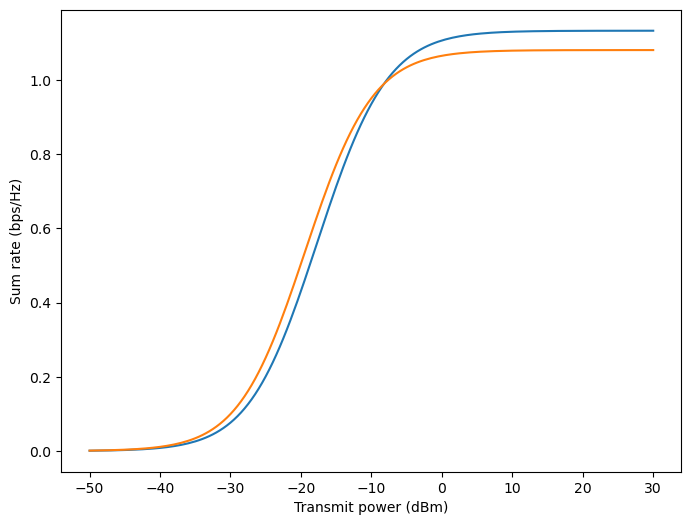

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(Pt, all_results[0]["rates"][2])
plt.plot(Pt, all_results[1]["rates"][2])
plt.xlabel("Transmit power (dBm)")
plt.ylabel("Sum rate (bps/Hz)")
plt.show()